# 残差网络（ResNet）

残差块<br>
![](./img/resnet1.png)

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

'''
输入 X
  ├─→ conv1 → bn1 → ReLU ─┐
  │                        ↓
  │                     conv2 → bn2 → Y
  │                        ↓
  │                      + X' (残差连接)
  │                        ↓
  │                     ReLU → 输出
  │
  └─→ [conv3] → X' (可选的维度变换路径)
'''
class Residual(nn.Module):  
    '''
    input_channels: 输入特征图的通道数
    num_channels: 输出特征图的通道数
    use_1x1conv: 是否使用1x1卷积进行维度匹配（默认为False）
    strides: 卷积步长，用于控制是否下采样（默认为1）
    '''
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        '''
        两个3x3卷积层：
        conv1: 第一个卷积，可以改变通道数和空间尺寸（通过stride）
        conv2: 第二个卷积，保持通道数和空间尺寸不变
        '''
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        '''
        可选的1x1卷积层：
        conv3: 当use_1x1conv=True时创建，用于将输入X变换到与输出Y相同的维度（通道数和空间尺寸），以便进行残差相加
        当 use_1x1conv=False：恒等映射（Identity Mapping），直接相加
        当 use_1x1conv=True：投影映射（Projection Mapping），通过1×1卷积对齐维度
        1. 改变通道数：1×1卷积核：对每个像素点进行"通道级线性组合"
        效果：C_in 个通道 → C_out 个通道；参数量：极少（仅 C_in × C_out 个权重）
        2. 调整空间尺寸
        stride=strides：当stride=2时，输出尺寸减半；效果：与主路径的降采样同步，保持空间尺寸一致
        '''
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        # 两个批归一化层：bn1和bn2: 分别对两个卷积层的输出进行批归一化，加速训练并稳定学习过程
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X))) # 第一次卷积+批归一化+ReLU激活
        Y = self.bn2(self.conv2(Y)) # 第二次卷积+批归一化（暂不激活）
        if self.conv3: # 如果1x1卷积存在（说明X和Y维度不匹配）
            X = self.conv3(X) # 如果需要，对输入进行维度变换
        Y += X # 残差连接：将输入加到输出上
        return F.relu(Y) # 最终ReLU激活后输出

输入和输出形状一致

In [2]:
'''
输入 X: (4, 3, 6, 6)
   │
   ├─→ conv1(3→3, stride=1) → bn1 → ReLU
   │                              ↓
   │                           conv2(3→3, stride=1) → bn2 → Y(4, 3, 6, 6)
   │                              ↓
   │                            + X(4, 3, 6, 6)  ← 残差连接（直接相加）
   │                              ↓
   └──────────────────────────→ ReLU → 输出 Y(4, 3, 6, 6)
创建一个残差块实例：input_channels=3：输入通道数3，num_channels=3：输出通道数3
结果：一个不改变维度的恒等残差块
'''
blk = Residual(3,3)
'''
创建一个随机输入张量，形状：(批次大小, 通道数, 高度, 宽度) = (4, 3, 6, 6)：模拟4张3通道的6×6图像
'''
X = torch.rand(4, 3, 6, 6)
# 前向传播：将X通过残差块处理
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

增加输出通道数的同时，减半输出的高和宽

In [3]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

ResNet模型<br>
![](./img/resnet2.png)

In [4]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

观察一下ResNet中不同模块的输入形状是如何变化的

In [5]:
X = torch.rand(size=(1, 1, 224, 224)) # 形状：(批量, 通道, 高, 宽)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


训练模型

loss 0.013, train acc 0.996, test acc 0.918
2684.3 examples/sec on cuda:0


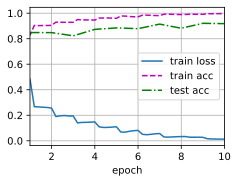

In [6]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

第1层输入层：输入为224×224×3三通道的图像。<br> 
第2层卷积层：输入为224×224×3，卷积核数量为64个；卷积核的尺寸大小为7×7×3；步幅为2（stride=2），填充为3（padding=3） 。 卷 积后得到shape为112×112×64的特征图输出。同时将输出的特征图经过批量规范化进行处理 <br> 
第3层最大池化层：输入为112×112×64，池化核为3×3，步幅为2（stride=2），填充为1（padding=1）后得到尺寸为56×56×64的池化层的特征图输出。

## 第一个残差部分
（1）输入为56×56×64，卷积核数量为64个；卷积核的尺寸大小为3×3×64；步幅为1（stride=1），填充为1（padding=1）；卷积后得到shape为56×56×64的特征图输出。 <br>
（2）输入为56×56×64，将输入的特征图经过批量规范化，然后经过RULE激活函数进行激活。输出的特征图大小形状不变，为56×56×64。 <br>
（3）输入为56×56×64，卷积核数量为64个；卷积核的尺寸大小为3×3×64；步幅为1（stride=1），填充为1（padding=1）；卷积后得到shape为56×56×64的特征图输出。 <br>
（4）输入为56×56×64，将输入的特征图经过批量规范化。输出的特征图大小形状不变，为56×56×64。<br> 
（5）此时，残差块将最初的输入特征图和经过最后一道批量规范化输出的特征图进行进行相加，得到最后的输出特征图经过RULE激活函数进行激活。

## 第二个残差部分 
（1）输入为56×56×64，卷积核数量为64个；卷积核的尺寸大小为3×3×64；步幅为1（stride=1），填充为1（padding=1）；卷积后得到shape为56×56×64的特征图输出。 <br>
（2）输入为56×56×64，将输入的特征图经过批量规范化，然后经过RULE激活函数进行激活。输出的特征图大小形状不变，为56×56×64。<br> 
（3）输入为56×56×64，卷积核数量为64个；卷积核的尺寸大小为3×3×64；步幅为1（stride=1），填充为1（padding=1）；卷积后得到shape为56×56×64的特征图输出。 <br>
（4）输入为56×56×64，将输入的特征图经过批量规范化。输出的特征图大小形状不变，为56×56×64。 <br>
（5）此时，残差块将最初的输入特征图和经过最后一道批量规范化输出的特征图进行进行相加，得到最后的输出特征图经过RULE激活函数进行激活。输出的特征图大小为56×56×64。

## 第3个残差部分
（1）输入为56×56×64，卷积核数量为128个；卷积核的尺寸大小为3×3×64 ； 步幅为2（stride=2） ， 填充为1（padding=1）；卷积后得到shape为28×28×128的特征图输出。 <br>
（2）输入为28×28×128，将输入的特征图经过批量规范化，然后经过RULE激活函数进行激活。输出的特征图大小形状不变，为28×28×128。 <br>
（3）输入为28×28×128，卷积核数量为128个；卷积核的尺寸大小为3×3×128 ；步幅为1（stride=1） ， 填充为1（padding=1）；卷积后得到shape为28×28×128的特征图输出。 <br>
（4）输入为28×28×128，将输入的特征图经过批量规范化。输出的特征图大小形状不变，为28×28×128。 <br>
（5）此时，残差块将最初的输入特征图和经过最后一道批量规范化输出的特征图的高宽和通道数不一样，一个为64一个为128；利用128个卷积核，卷积核尺寸大小为1×1×64；步幅为2（stride=2），填充为0（padding=0）得到输出为28×28×128的特征图，此时就可以将两个特征图进行相加操作，得到一个28×28×128的特征图；最后的输出特征图经过RULE激活函数进行激活。输出的特征图大小为28×28×128。

## 第4个残差部分
（1）输入为28×28×128，卷积核数量为128个；卷积核的尺寸大小为3×3×128 ；步幅为 1 （stride=1） ， 填 充 为 1（padding=1）；卷积后得到shape为28×28×128的特征图输出。 <br>
（2）输入为28×28×128，将输入的特征图经过批量规范化，然后经过RULE激活函数进行激活。输出的特征图大小形状不变，为28×28×128。 <br>
（3）输入为28×28×128，卷积核数量为128个；卷积核的尺寸大小为28×28×128 ；步幅为 1 （stride=1） ， 填充为 1（padding=1）；卷积后得到shape为28×28×128的特征图输出。 <br>
（4）输入为28×28×128，将输入的特征图经过批量规范化。输出的特征图大小形状不变，为28×28×128。 <br>
（5）此时，残差块将最初的输入特征图和经过最后一道批量规范化输出的特征图进行进行相加，得到最后的输出特征图经过RULE激活函数进行激活。输出的特征图大小为28×28×128。

## 第5个残差部分
（1）输入为28×28×128，卷积核数量为256个；卷积核的尺寸大小为3×3×128 ；步幅为 2 （stride=2） ， 填 充 为 1 （padding=1）；卷积后得到shape为14×14×256的特征图输出。 <br>
（2）输入为14×14×256，将输入的特征图经过批量规范化，然后经过RULE激活函数进行激活。输出的特征图大小形状不变，为14×14×256。 <br>
（3）输入为14×14×256，卷积核数量为256个；卷积核的尺寸大小为3×3×256 ；步幅为1 （stride=1） ， 填充为1（padding=1）；卷积后得到shape为14×14×256的特征图输出。 <br>
（4）输入为14×14×256，将输入的特征图经过批量规范化。输出的特征图大小形状不变，为14×14×256。 <br>
（5）此时，残差块将最初的输入特征图和经过最后一道批量规范化输出的特征图的高宽和通道数不一样，一个为128一个为256；利用256个卷积核，卷积核尺寸大小为1×1×128；步幅为2（stride=2），填充为0（padding=0）得到输出为14×14×256的特征图，此时就可以将两个特征图进行相加操作，得到一个14×14×256的特征图；得到最后的输出特征图经过RULE激活函数进行激活。输出的特征图大小为14×14×256。

## 第6个残差部分
（1）输入为14×14×256，卷积核数量为256个；卷积核的尺寸大小为3×3×256 ；步幅为1 （stride=1） ， 填充为1（padding=1）；卷积后得到shape为14×14×256的特征图输出。 <br>
（2）输入为14×14×256，将输入的特征图经过批量规范化，然后经过RULE激活函数进行激活。输出的特征图大小形状不变，为14×14×256。<br> 
（3）输入为14×14×256，卷积核数量为256个；卷积核的尺寸大小为14×14×256 ；步幅为1（stride=1） ， 填充为1（padding=1）；卷积后得到shape为14×14×256的特征图输出。 <br>
（4）输入为14×14×256，将输入的特征图经过批量规范化。输出的特征图大小形状不变，为214×14×256。 <br>
（5）此时，残差块将最初的输入特征图和经过最后一道批量规范化输出的特征图进行进行相加，得到最后的输出特征图经过RULE激活函数进行激活。输出的特征图大小为14×14×256。

## 第7个残差部分
（1）输入为14×14×256，卷积核数量为512个；卷积核的尺寸大小为3×3×256 ；步幅为2（ stride=2 ） ， 填充为1（padding=1）；卷积后得到shape为7×7×512的特征图输出。 <br>
（2）输入为7×7×512，将输入的特征图经过批量规范化，然后经过RULE激活函数进行激活。输出的特征图大小形状不变，为7×7×512。<br> 
（3）输入为7×7×512，卷积核数量为512个；卷积核的尺寸大小为3×3×512；步幅为1（stride=1），填充为1（padding=1）；卷积后得到shape为7×7×512的特征图输出。 <br>
（4）输入为7×7×512，将输入的特征图经过批量规范化。输出的特征图大小形状不变，为7×7×512。<br> 
（5）此时，残差块将最初的输入特征图和经过最后一道批量规范化输出的特征图的高宽和通道数不一样，一个为256一个为512；利用512个卷积核，卷积核尺寸大小为1×1×256；步幅为2（stride=2），填充为0（padding=0）得到输出为7×7×512的特征图，此时就可以将两个特征图进行相加操作，得到一个7×7×512的特征图；得到最后的输出特征图经过RULE激活函数进行激活。输出的特征图大小为7×7×512。

## 第8个残差部分
（1）输入为7×7×512，卷积核数量为512个；卷积核的尺寸大小为3×3×512；步幅为1（stride=1），填充为1（padding=1）；卷积后得到shape为7×7×512的特征图输出。 <br>
（2）输入为7×7×512，将输入的特征图经过批量规范化，然后经过RULE激活函数进行激活。输出的特征图大小形状不变，为7×7×512。<br> 
（3）输入为7×7×512，卷积核数量为512个；卷积核的尺寸大小为7×7×512；步幅为1（stride=1），填充为1（padding=1）；卷积后得到shape为7×7×512的特征图输出。 <br>
（4）输入为7×7×512，将输入的特征图经过批量规范化。输出的特征图大小形状不变，为7×7×512。 <br>
（5）此时，残差块将最初的输入特征图和经过最后一道批量规范化输出的特征图进行进行相加，得到最后的输出特征图经过RULE激活函数进行激活。输出的特征图大小为7×7×512。

## 第8块： 
## 全局平均池化模块：
输入为7×7×512。池化后得到shape为1×1×512的特征图输出。 
## Flatten层：
输入为1×1×512，输出为1×512。 
## 线性全连接层：
输入为1×512。线性全连接层神经元个数分别为10。最后一层全连接层用softmax输出10个分类。